# A simple example, solved three ways

1. CVXPY + MOSEK
2. SD ADMM
3. Coordinate descent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import cvxpy as cvx
sns.set_style('darkgrid')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import MeanSquareSmall, SmoothSecondDifference, SparseFirstDiffConvex
from osd.signal_decomp_bcd import run_bcd
from osd.utilities import progress
from osd.signal_decomp_admm import calc_obj

In [4]:
TOL = 1e-4

## Data generation

In [9]:
np.random.seed(42)
t = np.linspace(0, 1000, 500)
signal1 = np.sin(2 * np.pi * t * 1 / (500.)) + 10
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
y[55:90] = np.nan
y[270:360] = np.nan
X_real[:, np.isnan(y)] = np.nan
# ixs = np.random.choice(np.arange(len(y)), len(y) // 4, replace=False)
# y[ixs] = np.nan
print(np.sum(~np.isnan(y)) / len(y))
K, T = X_real.shape

0.75


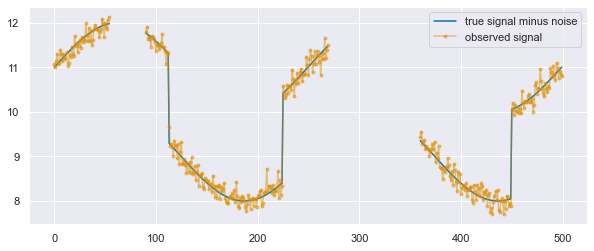

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(y, alpha=0.5, marker='.', label='observed signal')
plt.legend()
plt.show()

# CVXPY + MOSEK

In [11]:
c1 = MeanSquareSmall(size=T)
c2 = SmoothSecondDifference(weight=1e3/T)
c3 = SparseFirstDiffConvex(weight=2e0/T, vmax=1, vmin=-1)
components = [c1, c2, c3]
problem1 = Problem(y, components)

In [12]:
problem1.decompose(how='cvx')

In [13]:
opt_obj_val = problem1.objective_value
opt_obj_val

0.039507395560317966

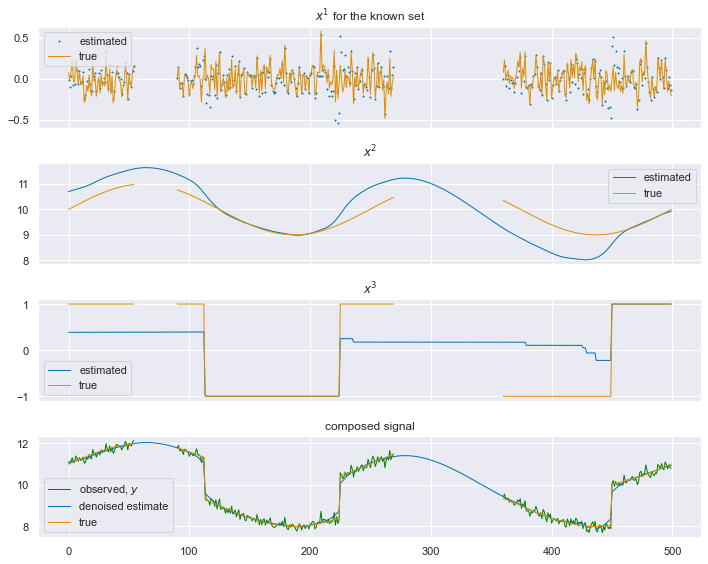

In [14]:
problem1.plot_decomposition(X_real=X_real);

# SD ADMM

In [15]:
problem2 = Problem(y, components)
problem2.decompose(how='admm', stopping_tolerance=1e-25, num_iter=1e5)
problem2.objective_value

factorizing matrix of size (500 x 500) with 2494 nnz---------] 0.0% ...0.00 sec   
done factorizing!


0.03946978025018977

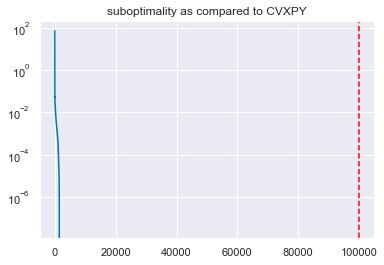

In [22]:
plt.figure()
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val)
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.show()

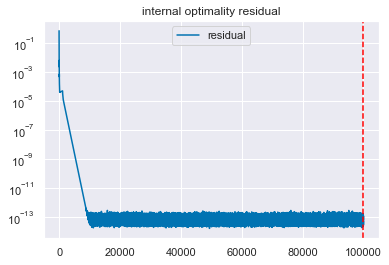

In [17]:
plt.figure()
plt.plot(problem2.admm_result['optimality_residual'], label='residual')
plt.axvline(problem2.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

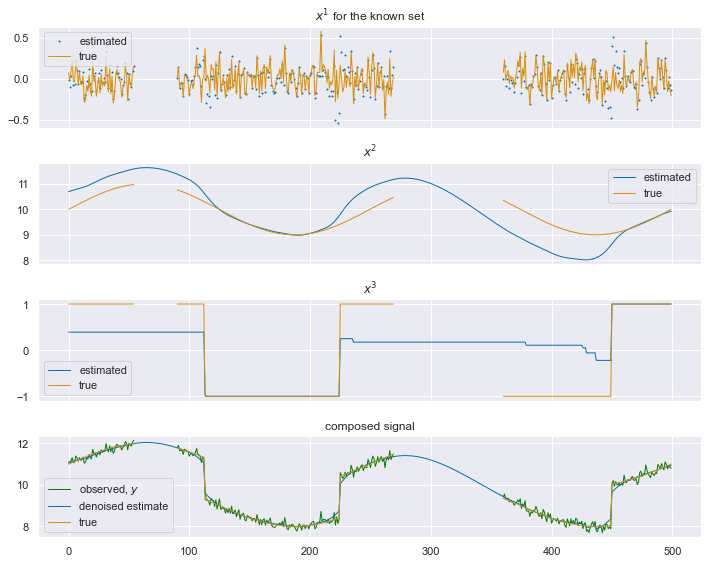

In [18]:
problem2.plot_decomposition(X_real=X_real);

# Coordinate Descent

In [23]:
problem3 = Problem(y, components)
problem3.decompose(how='bcd', stopping_tolerance=1e-25, num_iter=20000)
problem3.objective_value

[============================================================] 100.0% ...1411.32 sec


0.039469780250189504

In [24]:
len(problem3.bcd_result['obj_vals'])

20000

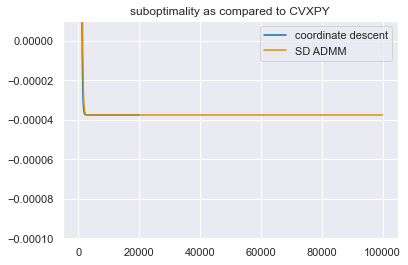

In [41]:
plt.figure()
plt.plot(problem3.bcd_result['obj_vals'] - opt_obj_val, label='coordinate descent')
plt.plot(problem2.admm_result['obj_vals'] - opt_obj_val, label='SD ADMM')
plt.title('suboptimality as compared to CVXPY')
plt.yscale('log')
plt.legend()
plt.show()

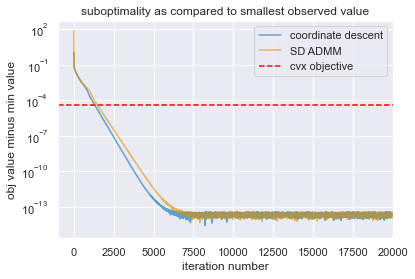

In [51]:
plt.figure()
minval = min(np.min(problem3.bcd_result['obj_vals']), np.min(problem2.admm_result['obj_vals']))
plt.plot(problem3.bcd_result['obj_vals'] - minval, label='coordinate descent', alpha=0.6)
plt.plot(problem2.admm_result['obj_vals'] - minval, label='SD ADMM', alpha=0.6)
plt.title('suboptimality as compared to smallest observed value')
plt.axhline(opt_obj_val - minval, label='cvx objective', color='red', ls='--')
plt.xlim(-1000, 20000)
plt.ylabel('obj value minus min value')
plt.xlabel('iteration number')
plt.yscale('log')
plt.legend()
plt.show()

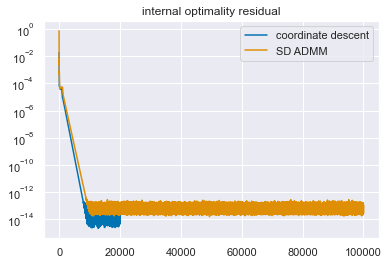

In [26]:
plt.figure()
plt.plot(problem3.bcd_result['optimality_residual'], label='coordinate descent')
plt.plot(problem2.admm_result['optimality_residual'], label='SD ADMM')
plt.yscale('log')
plt.title('internal optimality residual')
plt.legend()
plt.show()

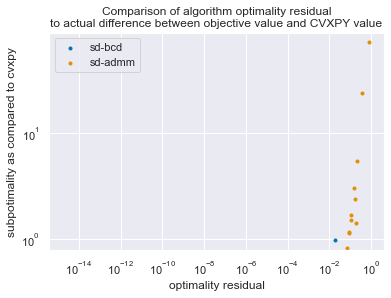

In [27]:
plt.scatter(problem3.bcd_result['optimality_residual'], problem3.bcd_result['obj_vals'] - opt_obj_val, 
            label='sd-bcd', marker='.')
plt.scatter(problem2.admm_result['optimality_residual'], problem2.admm_result['obj_vals'] - opt_obj_val, 
            label='sd-admm', marker='.')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(plt.ylim())
plt.xlabel('optimality residual')
plt.ylabel('subpotimality as compared to cvxpy')
# plt.gca().set_aspect('equal')
plt.legend()
plt.title('Comparison of algorithm optimality residual\nto actual difference between objective value and CVXPY value');

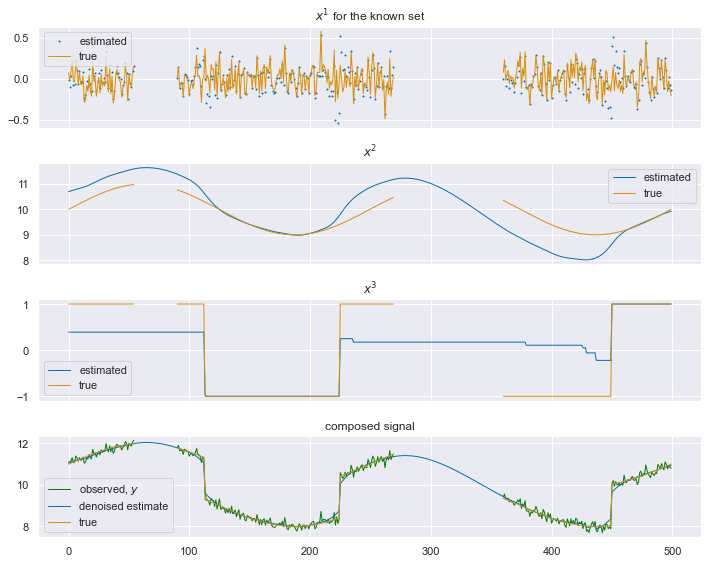

In [28]:
problem3.plot_decomposition(X_real=X_real);

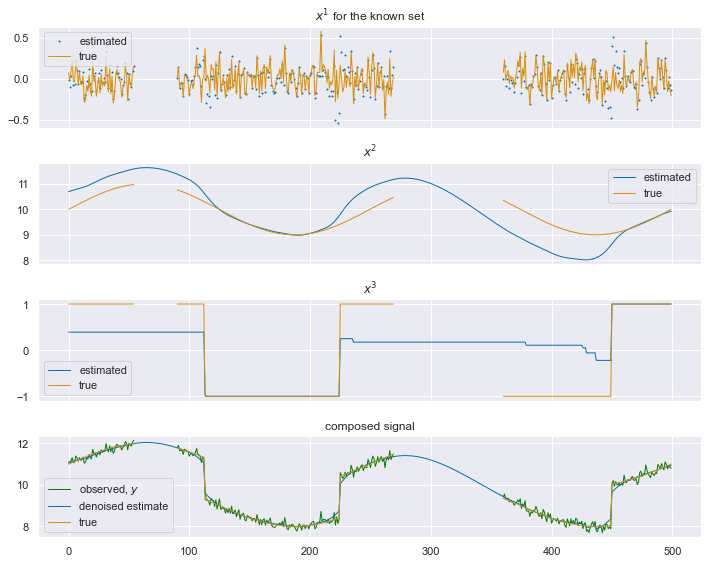

In [29]:
problem2.plot_decomposition(X_real=X_real);